In [1]:
import xarray as xr
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
from scipy import stats
import gsw

import warnings
warnings.filterwarnings("ignore")

In [2]:
def math_wind(speed, direc):
    md = 270-direc
    md = np.array(np.where(md>0,md,md+360))

    u = np.array([speed[i] * math.cos(math.radians(md[i])) for i in range(len(md))])
    v = np.array([speed[i] * math.sin(math.radians(md[i])) for i in range(len(md))])

    return u, v #remember that u is EW and v is NS

def calc_stats(x, y):
    stat = {}
    x_new = x[np.isfinite(x)]
    y_new = y[np.isfinite(x)]
    x = x_new[np.isfinite(y_new)]
    y = y_new[np.isfinite(y_new)]

    MSE = np.mean((y - x)**2)
    stat['RMSE'] = np.sqrt(MSE)
    stat['bias'] = np.mean(y) - np.mean(x)
    stat['WSS'] = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)
    stat['r'] = stats.pearsonr(x,y).statistic
    
    return stat

def plot_panel(ax, x, y, lims, units):
    stats = calc_stats(x, y)

    statstext = f"RMSE = {stats['RMSE']:.3f} {units}\nbias = {stats['bias']:.3f} {units}\nWSS = {stats['WSS']:.3f}\nr = {stats['r']:.3f}"
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    c = ax.text(0.5, 0.04, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return c

In [3]:
# length of season based on start and end of upwelling
season = [pd.to_datetime('2016-04-01',utc=True), pd.to_datetime('2016-09-01',utc=True),
 pd.to_datetime('2017-04-25',utc=True),pd.to_datetime('2017-10-21',utc=True),
 pd.to_datetime('2018-02-12',utc=True),pd.to_datetime('2018-09-05',utc=True),
 pd.to_datetime('2019-04-10',utc=True),pd.to_datetime('2019-11-03',utc=True),
 pd.to_datetime('2020-02-04',utc=True),pd.to_datetime('2020-10-20',utc=True),
 pd.to_datetime('2021-02-03',utc=True),pd.to_datetime('2021-09-29',utc=True),
 ]

In [4]:
grid = xr.open_dataset('/data1/parker/LO_data/grids/cas6/grid.nc')

# arrays for map of timeseries locations:
lat = np.array([])
lon = np.array([])
d = np.array([])
org = np.array([]) # organisation that took the measurement (onc, ios, ooi)
mes = np.array([]) # type of measurement (ctd or cur)

# ONC

## first working in barkley canyon
currents: scalar_1196714 <br>
ctd: scalar_1196717 <br>
oxygen: scalar_1196720

In [5]:
df = pd.read_pickle('/data1/bbeutel/LO_output/extract_cast/onc/scalar_1196714_uv.p')

lat = np.append(lat, df['latitude (degrees_north)'][0])
lon = np.append(lon, df['longitude (degrees_east)'][0])
d = np.append(d, df['depth (m)'][0])
org = np.append(org, "onc")
mes = np.append(mes, 'cur')

In [6]:
df['u'], df['v'] = math_wind(df['current_speed_calculated (m s-1)'], df['current_direction_calculated (degree)'])
# now that's a bit to much to plot, do average by day
df = df.set_index('datetime')
df = df.resample('D',axis=0).mean()

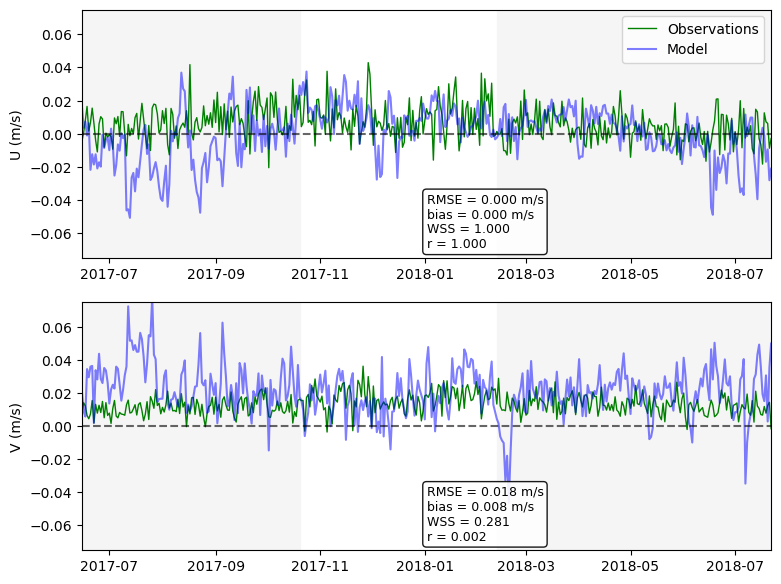

In [7]:
fig,ax = plt.subplots(2,1,figsize=(8,6))

ax[0].plot(df.index, df['u'],'g',lw=1,label='Observations')
ax[0].plot(df.index, df['model_u'],'b',label='Model',alpha=0.5)
ax[0].set_ylabel('U (m/s)')
ax[0].legend()
# plot the stats pannel
plot_panel(ax[0], df['u'], df['u'], (-0.1,0.1), 'm/s')

ax[1].plot(df.index, df['v'],'g',lw=1,label='Observations')
ax[1].plot(df.index, df['model_v'],'b',label='Model',alpha=0.5)
ax[1].set_ylabel('V (m/s)')
# plot the stats pannel
plot_panel(ax[1], df['v'], df['model_v'], (-0.1,0.1), 'm/s')

for i in range(len(ax)):
    ax[i].set_ylim([-0.075,0.075])
    ax[i].set_xlim([np.min(df.index),np.max(df.index)])
    ax[i].plot([np.min(df.index),np.max(df.index)],[0,0],'k--',alpha=0.6)
    
    for j in range(0, len(season),2):
        ax[i].fill_between(df.index, -5000, 85000, where=(df.index<season[j+1])&(df.index>=season[j]), color='whitesmoke')
plt.tight_layout()



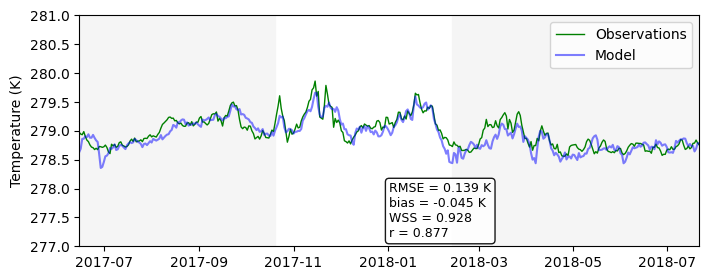

In [8]:
# what about temperature?
fig,ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(df.index, df['Temperature (K)'],'g',lw=1,label='Observations')
ax.plot(df.index, df['model_t'],'b',label='Model',alpha=0.5)
ax.set_ylabel('Temperature (K)')
ax.legend()
# plot the stats pannel
plot_panel(ax, df['Temperature (K)'], df['model_t'], (277,281), 'K')
ax.set_xlim([np.min(df.index),np.max(df.index)])

for j in range(0, len(season),2):
        ax.fill_between(df.index, -5000, 85000, where=(df.index<season[j+1])&(df.index>=season[j]), color='whitesmoke')

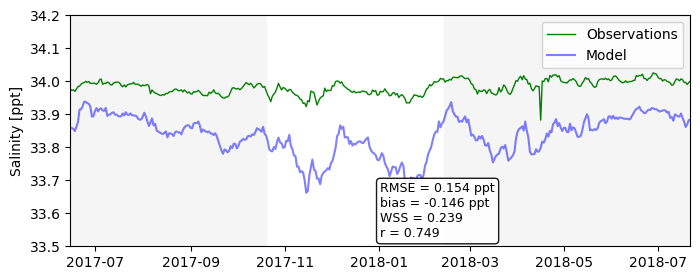

In [9]:
# salinity?
df = pd.read_pickle('/data1/bbeutel/LO_output/extract_cast/onc/scalar_1196717_ctd.p').set_index('datetime').resample('D',axis=0).mean()

# reapeat bc this also has ctd measurements at the same location and depth
lat = np.append(lat, df['latitude (degrees_north)'][0])
lon = np.append(lon, df['longitude (degrees_east)'][0])
d = np.append(d, df['depth (m)'][0])
org = np.append(org, "onc")
mes = np.append(mes, 'ctd')

fig,ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(df.index, df['salinity (1e-3)'],'g',lw=1,label='Observations')
ax.plot(df.index, df['model_s'],'b',label='Model',alpha=0.5)
ax.set_ylabel('Salinity [ppt]')
ax.legend()
# plot the stats pannel
plot_panel(ax, df['salinity (1e-3)'], df['model_s'], (33.5,34.2), 'ppt')
ax.set_xlim([np.min(df.index),np.max(df.index)])

for j in range(0, len(season),2):
        ax.fill_between(df.index, -5000, 85000, where=(df.index<season[j+1])&(df.index>=season[j]), color='whitesmoke')

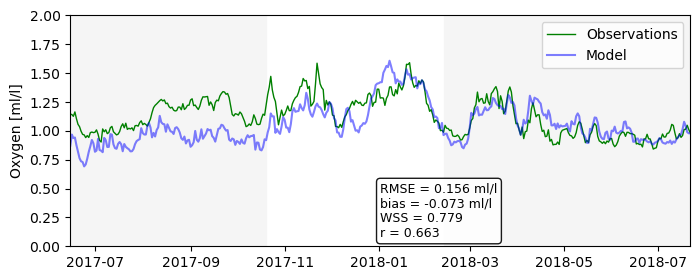

In [10]:
# oxygen?

do = pd.read_pickle('/data1/bbeutel/LO_output/extract_cast/onc/scalar_1196720_oxy.p').set_index('datetime').resample('D',axis=0).mean()

fig,ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(do.index, do['oxygen_corrected (ml/l)'],'g',lw=1,label='Observations')
ax.plot(do.index, do['model_o'],'b',label='Model',alpha=0.5)
ax.set_ylabel('Oxygen [ml/l]')
ax.legend()
# plot the stats pannel
plot_panel(ax, do['oxygen_corrected (ml/l)'], do['model_o'], (0,2), 'ml/l')
ax.set_xlim([np.min(do.index),np.max(do.index)])

for j in range(0, len(season),2):
        ax.fill_between(df.index, -5000, 85000, where=(df.index<season[j+1])&(df.index>=season[j]), color='whitesmoke')

## Endeavour North
curent: scalar_1200222
ctd: scalar_1200219 


In [12]:
df = pd.read_pickle('/data1/bbeutel/LO_output/extract_cast/onc/scalar_1200222_uv.p')

# reapeat bc this also has ctd measurements at the same location and depth
lat = np.append(lat, df['latitude (degrees_north)'][0])
lon = np.append(lon, df['longitude (degrees_east)'][0])
d = np.append(d, df['depth (m)'][0])
org = np.append(org, "onc")
mes = np.append(mes, 'cur')

df['u'], df['v'] = math_wind(df['current_speed_calculated (m s-1)'], df['current_direction_calculated (degree)'])
# now that's a bit to much to plot, do average by day
df = df.set_index('datetime')
df = df.resample('D',axis=0).mean()

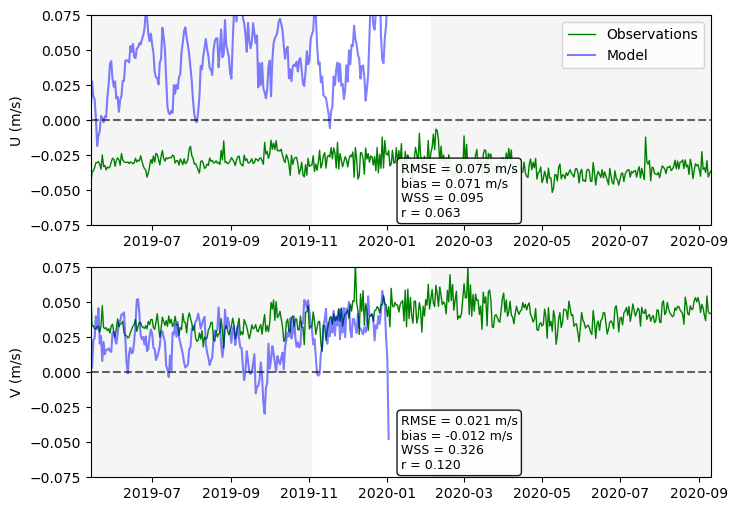

In [13]:
fig,ax = plt.subplots(2,1,figsize=(8,6))

ax[0].plot(df.index, df['u'],'g',lw=1,label='Observations')
ax[0].plot(df.index, df['model_u'],'b',label='Model',alpha=0.5)
ax[0].set_ylabel('U (m/s)')
ax[0].legend()
# plot the stats pannel
plot_panel(ax[0], df['u'], df['model_u'], (-0.1,0.1), 'm/s')

ax[1].plot(df.index, df['v'],'g',lw=1,label='Observations')
ax[1].plot(df.index, df['model_v'],'b',label='Model',alpha=0.5)
ax[1].set_ylabel('V (m/s)')
# plot the stats pannel
plot_panel(ax[1], df['v'], df['model_v'], (-0.1,0.1), 'm/s')

for i in range(len(ax)):
    ax[i].set_ylim([-0.075,0.075])
    ax[i].set_xlim([np.min(df.index),np.max(df.index)])
    ax[i].plot([np.min(df.index),np.max(df.index)],[0,0],'k--',alpha=0.6)

    for j in range(0, len(season),2):
        ax[i].fill_between(df.index, -5000, 85000, where=(df.index<season[j+1])&(df.index>=season[j]), color='whitesmoke')

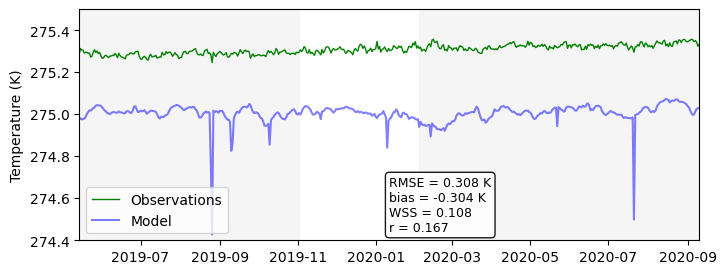

In [14]:
# what about temperature?
fig,ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(df.index, df['Temperature (K)'],'g',lw=1,label='Observations')
ax.plot(df.index, df['model_t'],'b',label='Model',alpha=0.5)
ax.set_ylabel('Temperature (K)')
ax.legend(loc="lower left")
# plot the stats pannel
plot_panel(ax, df['Temperature (K)'], df['model_t'], (274.4,275.5), 'K')
ax.set_xlim([np.min(df.index),np.max(df.index)])

for j in range(0, len(season),2):
    ax.fill_between(df.index, -5000, 85000, where=(df.index<season[j+1])&(df.index>=season[j]), color='whitesmoke')

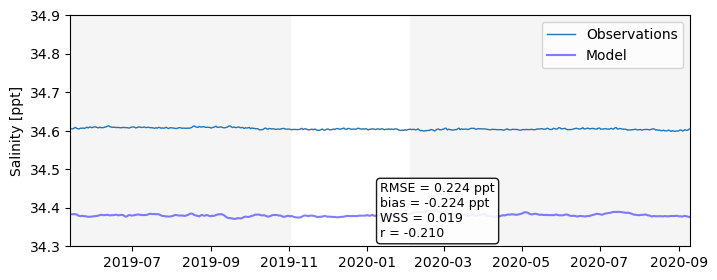

In [15]:
# salinity?
df = pd.read_pickle('/data1/bbeutel/LO_output/extract_cast/onc/scalar_1200219_ctd.p').set_index('datetime').resample('D',axis=0).mean()

# reapeat bc this also has ctd measurements at the same location and depth
lat = np.append(lat, df['latitude (degrees_north)'][0])
lon = np.append(lon, df['longitude (degrees_east)'][0])
d = np.append(d, df['depth (m)'][0])
org = np.append(org, "onc")
mes = np.append(mes, 'ctd')

fig,ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(df.index, df['salinity (1e-3)'], lw=1,label='Observations')
ax.plot(df.index, df['model_s'],'b',label='Model',alpha=0.5)
ax.set_ylabel('Salinity [ppt]')
ax.legend()
# plot the stats pannel
plot_panel(ax, df['salinity (1e-3)'], df['model_s'], (34.3,34.9), 'ppt')
ax.set_xlim([np.min(df.index),np.max(df.index)])

for j in range(0, len(season),2):
    ax.fill_between(df.index, -5000, 85000, where=(df.index<season[j+1])&(df.index>=season[j]), color='whitesmoke')

# IOS
narrow down date range on erddap - chose profile names based on CIOOS pacific site

### currents
*north shelf*: "2022-069-0061" "2021-069-0060" (49.28833 -126.602) NOTE: new model not here yet <br>
*shelf edge west of JdF*: "2013-050-0052" "2014-020-0053" "2015-046-0054" "2016-012-0055" "2017-023-0056" "2018-025-0057" "2019-069-0058" (48.548668 -126.18433, d=35)

### ctd 
*north shelf*: "2020-069-0059" (49.29 -126.60516, d=35) <br>
*shelf edge west of JdF*: "2013-050-0000" "2014-020-0000" "2014-020-0053" "2015-046-0000" "2016-012-0055" "2017-023-0056" "2018-025-0057" "2019-069-0058" "2021-069-0060" (48.5386 -126.19523)

## north shelf:

In [5]:
df = pd.read_pickle("/data1/bbeutel/LO_output/extract_cast/ios/-126.60516_49.29_ctd.p")

lat = np.append(lat, df['latitude (degrees_north)'][0])
lon = np.append(lon, df['longitude (degrees_east)'][0])
d = np.append(d, df['instrument_depth (m)'][0])
org = np.append(org, "ios")
mes = np.append(mes, 'ctd')

df['model_t'] = df['model_t']-273

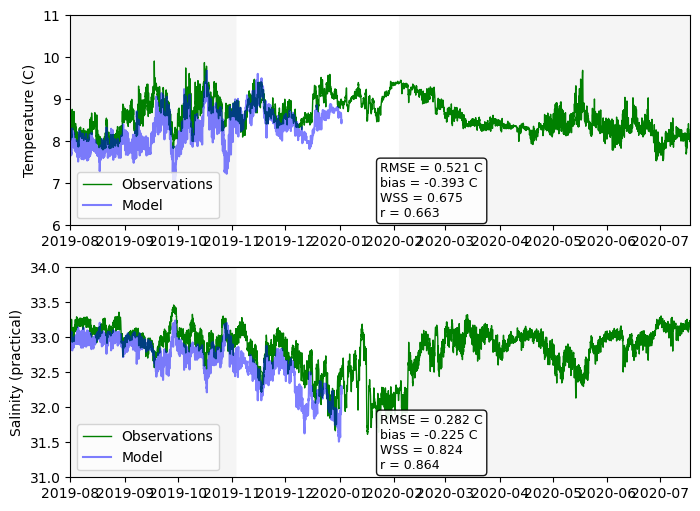

In [6]:
fig,ax = plt.subplots(2,1,figsize=(8,6))

ax[0].plot(df.datetime, df['sea_water_temperature (degC)'],'g',lw=1,label='Observations')
ax[0].plot(df.datetime, df['model_t'],'b',label='Model',alpha=0.5)
ax[0].set_ylabel('Temperature (C)')
ax[0].legend(loc="lower left")
# plot the stats pannel
plot_panel(ax[0], df['sea_water_temperature (degC)'], df['model_t'], (6,11), 'C')
ax[0].set_xlim([np.min(df.datetime),np.max(df.datetime)])

ax[1].plot(df.datetime, df['sea_water_practical_salinity (PSS-78)'],'g',lw=1,label='Observations')
ax[1].plot(df.datetime, df['model_s'],'b',label='Model',alpha=0.5)
ax[1].set_ylabel('Salinity (practical)')
ax[1].legend(loc="lower left")
# plot the stats pannel
plot_panel(ax[1], df['sea_water_practical_salinity (PSS-78)'], df['model_s'], (31,34), 'C')
ax[1].set_xlim([np.min(df.datetime),np.max(df.datetime)])

for j in range(0, len(season),2):
    ax[0].fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')
    ax[1].fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')


In [7]:
# df = pd.read_pickle("/data1/bbeutel/LO_output/extract_cast/ios/-126.60290000000002_49.28833_cur.p") # not yet at these dates

# lat = np.append(lat, df['latitude (degrees_north)'][0])
# lon = np.append(lon, df['longitude (degrees_east)'][0])
# d = np.append(d, df['instrument_depth (m)'][0])
# org = np.append(org, "ios")
# mes = np.append(mes, 'cur')

# # convert model w to cm/s 
# df['model_w'] = df['model_w']*100

In [8]:
# df

,longitude (degrees_east),latitude (degrees_north),instrument_depth (m),PRESPR01 (decibar),LCEWEL01 (m/s),LCNSEL01 (m/s),LRZASP01 (m/s),datetime,model_u,model_v,model_w
0,-126.60290,49.28833,35.0,38.697667,-0.098333,0.011667,0.015667,2021-06-03 02:00:00+00:00,NaN,NaN,NaN
1,-126.60290,49.28833,35.0,38.705000,-0.130167,-0.011333,0.023167,2021-06-03 03:00:00+00:00,NaN,NaN,NaN
2,-126.60290,49.28833,35.0,38.575667,-0.065500,0.014167,0.002000,2021-06-03 04:00:00+00:00,NaN,NaN,NaN
3,-126.60290,49.28833,35.0,38.269500,0.009333,-0.013333,0.004833,2021-06-03 05:00:00+00:00,NaN,NaN,NaN
4,-126.60290,49.28833,35.0,37.889667,0.047667,-0.065833,0.000667,2021-06-03 06:00:00+00:00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16119,-126.60569,49.29055,35.0,26.900000,-0.033167,0.014500,0.013000,2021-06-02 21:00:00+00:00,NaN,NaN,NaN
16120,-126.60569,49.29055,35.0,27.259667,-0.074833,0.013167,0.002833,2021-06-02 22:00:00+00:00,NaN,NaN,NaN
16121,-126.60569,49.29055,35.0,27.935167,-0.156667,0.043167,0.012833,2021-06-02 23:00:00+00:00,NaN,NaN,NaN
16122,-126.60569,49.29055,35.0,28.378833,-0.201833,0.009500,0.002167,2021-06-03 00:00:00+00:00,NaN,NaN,NaN


In [10]:
# fig,ax = plt.subplots(3,1,figsize=(8,9))

# ax[0].plot(df.datetime, df['LCEWEL01 (m/s)'],'g',lw=1,label='Observations')
# ax[0].plot(df.datetime, df['model_u'],'b',label='Model',alpha=0.5)
# ax[0].set_ylabel('U (m/s)')
# ax[0].legend()
# # plot the stats pannel
# plot_panel(ax[0], df['LCEWEL01 (m/s)'], df['model_u'], (-0.1,0.1), 'm/s')

# ax[1].plot(df.datetime, df['LCNSEL01 (m/s)'],'g',lw=1,label='Observations')
# ax[1].plot(df.datetime, df['model_v'],'b',label='Model',alpha=0.5)
# ax[1].set_ylabel('V (m/s)')
# # plot the stats pannel
# plot_panel(ax[1], df['LCNSEL01 (m/s)'], df['model_v'], (-0.1,0.1), 'm/s')

# ax[2].plot(df.datetime, df['LRZASP01 (m/s)'],'g',lw=1,label='Observations')
# ax[2].plot(df.datetime, df['model_w'],'b',label='Model',alpha=0.5)
# ax[2].set_ylabel('W (cm/s)')
# # plot the stats pannel
# plot_panel(ax[2], df['LRZASP01 (m/s)'], df['model_w'], (-0.1,0.1), 'm/s')

# for i in range(len(ax)):
#     ax[i].set_ylim([-1,1])
#     ax[i].set_xlim([np.min(df.datetime),np.max(df.datetime)])
#     ax[i].plot([np.min(df.datetime),np.max(df.datetime)],[0,0],'k--',alpha=0.6)

#     for j in range(0, len(season),2):
#         ax[i].fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')


## shelf slope west of JdF:

In [16]:
df = pd.read_pickle("/data1/bbeutel/LO_output/extract_cast/ios/-126.60516_49.29_ctd.p")

lat = np.append(lat, df['latitude (degrees_north)'][0])
lon = np.append(lon, df['longitude (degrees_east)'][0])
d = np.append(d, df['instrument_depth (m)'][0])
org = np.append(org, "ios")
mes = np.append(mes, 'ctd')

df['model_t'] = df['model_t']-273
df.head()

,longitude (degrees_east),latitude (degrees_north),sea_water_pressure (dbar),instrument_depth (m),sea_water_temperature (degC),sea_water_practical_salinity (PSS-78),DOXYZZ01 (mL/L),datetime,model_s,model_t,model_o
0,-126.60516,49.29,70.082333,68.5,8.373650,33.117525,NaN,2019-08-01 00:00:00+00:00,32.869138,8.161124,2.801528
1,-126.60516,49.29,69.817917,68.5,8.355908,33.117608,NaN,2019-08-01 01:00:00+00:00,32.900812,8.094708,2.784287
2,-126.60516,49.29,69.863833,68.5,8.313017,33.096008,NaN,2019-08-01 02:00:00+00:00,32.961065,7.972652,2.782334
3,-126.60516,49.29,70.175417,68.5,8.024317,33.135158,NaN,2019-08-01 03:00:00+00:00,33.011785,7.857541,2.795063
4,-126.60516,49.29,70.681500,68.5,8.028733,33.203267,NaN,2019-08-01 04:00:00+00:00,33.029932,7.823608,2.798084


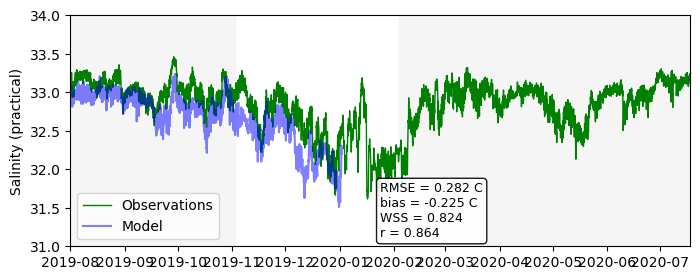

In [18]:
fig,ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(df.datetime, df['sea_water_practical_salinity (PSS-78)'],'g',lw=1,label='Observations')
ax.plot(df.datetime, df['model_s'],'b',label='Model',alpha=0.5)
ax.set_ylabel('Salinity (practical)')
ax.legend(loc="lower left")
# plot the stats pannel
plot_panel(ax, df['sea_water_practical_salinity (PSS-78)'], df['model_s'], (31,34), 'C')
ax.set_xlim([np.min(df.datetime),np.max(df.datetime)])

# ax[1].plot(df.datetime, df['DOXYZZ01 (mL/L)'],'g',lw=1,label='Observations')
# ax[1].plot(df.datetime, df['model_o'],'b',label='Model',alpha=0.5)
# ax[1].set_ylabel('Dissolved Oxygen (mL/L)')
# ax[1].legend(loc="lower left")
# # plot the stats pannel
# plot_panel(ax[1], df['DOXYZZ01 (mL/L)'], df['model_o'], (0,10), 'mL/L')
# ax[1].set_xlim([np.min(df.datetime),np.max(df.datetime)])

for j in range(0, len(season),2):
    ax.fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')
    # ax[1].fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')

In [19]:
df = pd.read_pickle("/data1/bbeutel/LO_output/extract_cast/ios/-126.60290000000002_49.28833_cur.p")
# python3 ios_timeseries_currents.py "2017-023-0056" "2018-025-0057" "2021-069-0060"

# lat = np.append(lat, df['latitude (degrees_north)'][0])
# lon = np.append(lon, df['longitude (degrees_east)'][0])
# d = np.append(d, df['instrument_depth (m)'][0])
# org = np.append(org, "ios")
# mes = np.append(mes, 'cur')

# convert model w to cm/s 
# basically erdapp says the units are m/s for w BUT the instrument manual says its measured in cm/s
# and based on the fact that the names are straight from the instrument then i doubt post-processing was done
df['model_w'] = df['model_w']*100 

In [21]:
df.head()

,longitude (degrees_east),latitude (degrees_north),instrument_depth (m),PRESPR01 (decibar),LCEWEL01 (m/s),LCNSEL01 (m/s),LRZASP01 (m/s),datetime,model_u,model_v,model_w
0,-126.6029,49.28833,35.0,38.697667,-0.098333,0.011667,0.015667,2021-06-03 02:00:00+00:00,NaN,NaN,NaN
1,-126.6029,49.28833,35.0,38.705000,-0.130167,-0.011333,0.023167,2021-06-03 03:00:00+00:00,NaN,NaN,NaN
2,-126.6029,49.28833,35.0,38.575667,-0.065500,0.014167,0.002000,2021-06-03 04:00:00+00:00,NaN,NaN,NaN
3,-126.6029,49.28833,35.0,38.269500,0.009333,-0.013333,0.004833,2021-06-03 05:00:00+00:00,NaN,NaN,NaN
4,-126.6029,49.28833,35.0,37.889667,0.047667,-0.065833,0.000667,2021-06-03 06:00:00+00:00,NaN,NaN,NaN


ValueError: x and y must have length at least 2.

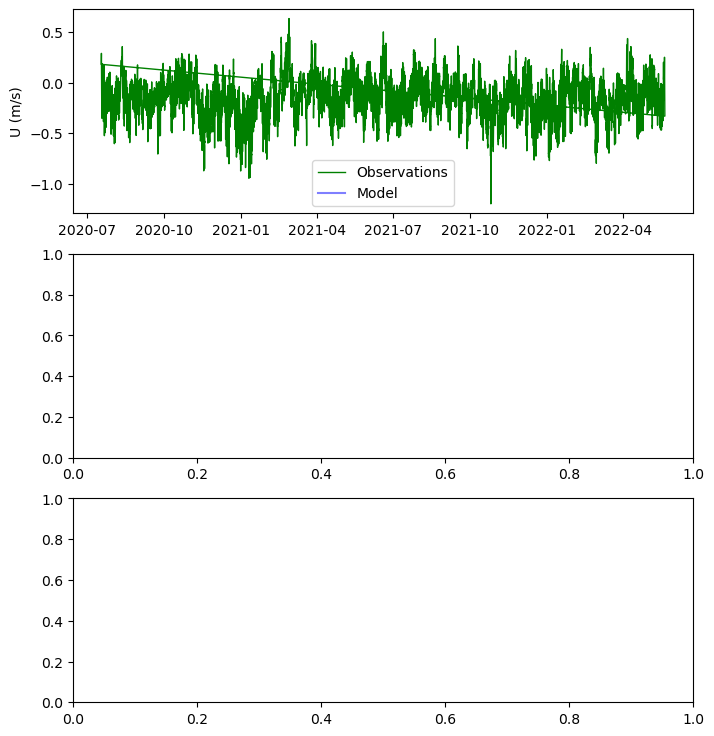

In [20]:
fig,ax = plt.subplots(3,1,figsize=(8,9))

ax[0].plot(df.datetime, df['LCEWEL01 (m/s)'],'g',lw=1,label='Observations')
ax[0].plot(df.datetime, df['model_u'],'b',label='Model',alpha=0.5)
ax[0].set_ylabel('U (m/s)')
ax[0].legend()
# plot the stats pannel
plot_panel(ax[0], df['LCEWEL01 (m/s)'], df['model_u'], (-0.1,0.1), 'm/s')

ax[1].plot(df.datetime, df['LCNSEL01 (m/s)'],'g',lw=1,label='Observations')
ax[1].plot(df.datetime, df['model_v'],'b',label='Model',alpha=0.5)
ax[1].set_ylabel('V (m/s)')
# plot the stats pannel
plot_panel(ax[1], df['LCNSEL01 (m/s)'], df['model_v'], (-0.1,0.1), 'm/s')

ax[2].plot(df.datetime, df['LRZASP01 (m/s)'],'g',lw=1,label='Observations')
ax[2].plot(df.datetime, df['model_w'],'b',label='Model',alpha=0.5)
ax[2].set_ylabel('W (cm/s)')
# plot the stats pannel
plot_panel(ax[2], df['LRZASP01 (m/s)'], df['model_w'], (-0.1,0.1), 'm/s')

for i in range(len(ax)):
    ax[i].set_ylim([-1,1])
    ax[i].set_xlim([np.min(df.datetime),np.max(df.datetime)])
    ax[i].plot([np.min(df.datetime),np.max(df.datetime)],[0,0],'k--',alpha=0.6)

    for j in range(0, len(season),2):
        ax[i].fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')

# OOI

### close to shore, near surface

In [24]:
df = pd.read_pickle("/data1/bbeutel/LO_output/extract_cast/ooi/ooi-ce06issm_ns.p")

lat = np.append(lat, df['latitude (degrees_north)'][0])
lon = np.append(lon, df['longitude (degrees_east)'][0])
d = np.append(d, gsw.z_from_p(df['sea_water_pressure (decibars)'][0], df['latitude (degrees_north)'][0]))
org = np.append(org, "ioo")
mes = np.append(mes, 'ctd')

# repeat bc has current and ctd
lat = np.append(lat, df['latitude (degrees_north)'][0])
lon = np.append(lon, df['longitude (degrees_east)'][0])
d = np.append(d, gsw.z_from_p(df['sea_water_pressure (decibars)'][0], df['latitude (degrees_north)'][0]))
org = np.append(org, "ioo")
mes = np.append(mes, 'cur')

# undo a conversion you did wrong while downloading
df['model_o'] = df['model_o']*1000
df['model_n'] = df['model_n']*1000

df.head()

,longitude (degrees_east),latitude (degrees_north),sea_water_pressure (decibars),sea_water_density (kg.m-3),sea_water_temperature (degree_Celsius),sea_water_practical_salinity (1e-3),eastward_sea_water_velocity (m.s-1),northward_sea_water_velocity (m.s-1),upward_sea_water_velocity (m.s-1),mole_concentration_of_dissolved_molecular_oxygen_in_sea_water (micromol.L-1),mole_concentration_of_nitrate_in_sea_water (micromol.L-1),mole_concentration_of_nitrate_in_sea_water_full (micromol.L-1),datetime,model_s,model_t,model_o,model_n,model_u,model_v,model_w
0,-124.27005,47.13447,7.454203,1022.087028,8.852251,28.492826,0.046919,-0.075048,0.02025,358.70975,NaN,NaN,2016-12-18 00:00:00+00:00,31.015535,9.914089,299.424347,0.081685,0.077009,-0.166266,-0.000126
1,-124.27005,47.13447,7.425894,1022.036060,8.816366,28.421209,0.075752,-0.114239,0.01125,356.03925,NaN,NaN,2016-12-18 01:00:00+00:00,30.788534,9.919616,299.219757,0.168368,0.027010,-0.155465,-0.000746
2,-124.27005,47.13447,7.362413,1022.105730,8.875954,28.521653,0.054252,-0.125771,-0.00100,355.91575,NaN,NaN,2016-12-18 02:00:00+00:00,30.552273,9.871748,299.006104,0.246847,-0.023654,-0.111295,0.000026
3,-124.27005,47.13447,7.509700,1022.109243,8.811358,28.513451,0.047899,-0.127074,-0.00125,356.22025,NaN,NaN,2016-12-18 03:00:00+00:00,30.551138,9.858210,298.976044,0.251234,-0.030571,-0.087972,0.000005
4,-124.27005,47.13447,7.470736,1022.092630,8.753965,28.481883,0.089664,-0.101057,0.00200,356.60000,NaN,NaN,2016-12-18 04:00:00+00:00,30.477498,9.815629,298.976501,0.254598,-0.035299,-0.065653,-0.000488


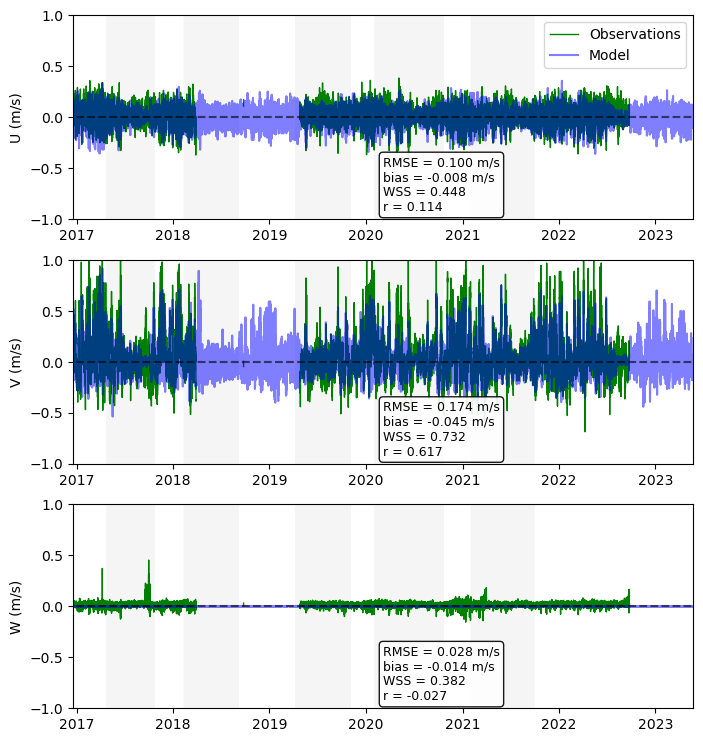

In [25]:
fig,ax = plt.subplots(3,1,figsize=(8,9))

ax[0].plot(df.datetime, df['eastward_sea_water_velocity (m.s-1)'],'g',lw=1,label='Observations')
ax[0].plot(df.datetime, df['model_u'],'b',label='Model',alpha=0.5)
ax[0].set_ylabel('U (m/s)')
ax[0].legend()
# plot the stats pannel
plot_panel(ax[0], df['eastward_sea_water_velocity (m.s-1)'], df['model_u'], (-0.1,0.1), 'm/s')

ax[1].plot(df.datetime, df['northward_sea_water_velocity (m.s-1)'],'g',lw=1,label='Observations')
ax[1].plot(df.datetime, df['model_v'],'b',label='Model',alpha=0.5)
ax[1].set_ylabel('V (m/s)')
# plot the stats pannel
plot_panel(ax[1], df['northward_sea_water_velocity (m.s-1)'], df['model_v'], (-0.1,0.1), 'm/s')

ax[2].plot(df.datetime, df['upward_sea_water_velocity (m.s-1)'],'g',lw=1,label='Observations')
ax[2].plot(df.datetime, df['model_w'],'b',label='Model',alpha=0.5)
ax[2].set_ylabel('W (m/s)')
# plot the stats pannel
plot_panel(ax[2], df['upward_sea_water_velocity (m.s-1)'], df['model_w'], (-0.1,0.1), 'm/s')

for i in range(len(ax)):
    ax[i].set_ylim([-1,1])
    ax[i].set_xlim([np.min(df.datetime),np.max(df.datetime)])
    ax[i].plot([np.min(df.index),np.max(df.index)],[0,0],'k--',alpha=0.6)

    for j in range(0, len(season),2):
        ax[i].fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')

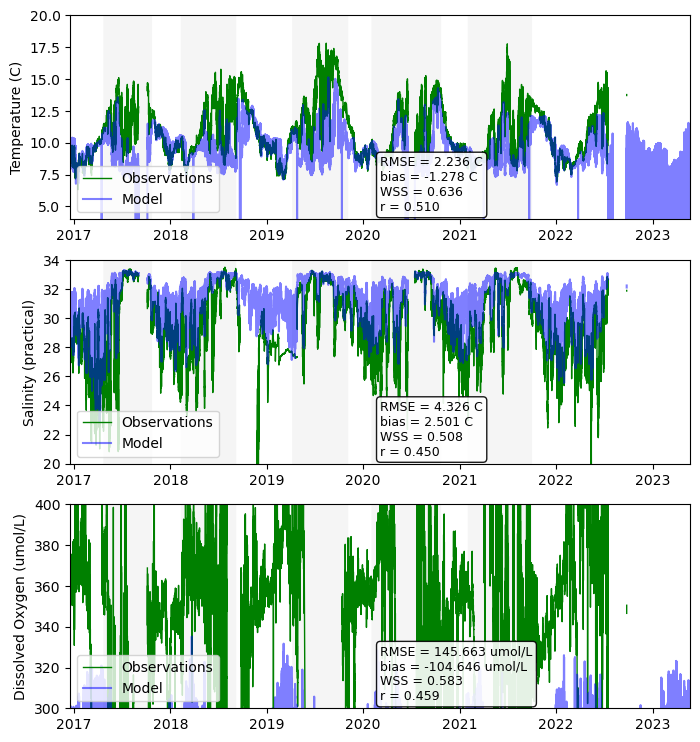

In [26]:
fig,ax = plt.subplots(3,1,figsize=(8,9))

ax[0].plot(df.datetime, df['sea_water_temperature (degree_Celsius)'],'g',lw=1,label='Observations')
ax[0].plot(df.datetime, df['model_t'],'b',label='Model',alpha=0.5)
ax[0].set_ylabel('Temperature (C)')
ax[0].legend(loc="lower left")
# plot the stats pannel
plot_panel(ax[0], df['sea_water_temperature (degree_Celsius)'], df['model_t'], (4,20), 'C')
ax[0].set_xlim([np.min(df.datetime),np.max(df.datetime)])

ax[1].plot(df.datetime, df['sea_water_practical_salinity (1e-3)'],'g',lw=1,label='Observations')
ax[1].plot(df.datetime, df['model_s'],'b',label='Model',alpha=0.5)
ax[1].set_ylabel('Salinity (practical)')
ax[1].legend(loc="lower left")
# plot the stats pannel
plot_panel(ax[1], df['sea_water_practical_salinity (1e-3)'], df['model_s'], (20,34), 'C')
ax[1].set_xlim([np.min(df.datetime),np.max(df.datetime)])

ax[2].plot(df.datetime, df['mole_concentration_of_dissolved_molecular_oxygen_in_sea_water (micromol.L-1)'],'g',lw=1,label='Observations')
ax[2].plot(df.datetime, df['model_o'],'b',label='Model',alpha=0.5)
ax[2].set_ylabel('Dissolved Oxygen (umol/L)')
ax[2].legend(loc="lower left")
# plot the stats pannel
plot_panel(ax[2], df['mole_concentration_of_dissolved_molecular_oxygen_in_sea_water (micromol.L-1)'], df['model_o'], (300,400), 'umol/L')
ax[2].set_xlim([np.min(df.datetime),np.max(df.datetime)])

for j in range(0, len(season),2):
    ax[0].fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')
    ax[1].fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')
    ax[2].fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')


### close to shore, surface 

In [30]:
df.columns

Index(['longitude (degrees_east)', 'latitude (degrees_north)',
       'instrument_depth (m)', 'PRESPR01 (decibar)', 'LCEWEL01 (m/s)',
       'LCNSEL01 (m/s)', 'LRZASP01 (m/s)', 'datetime', 'model_u', 'model_v',
       'model_w'],
      dtype='object')

In [27]:
df = pd.read_pickle("/data1/bbeutel/LO_output/extract_cast/ooi/ooi-ce06issm_s.p")

lat = np.append(lat, df['latitude (degrees_north)'][0])
lon = np.append(lon, df['longitude (degrees_east)'][0])
d = np.append(d, gsw.z_from_p(df['sea_water_pressure (decibars)'][0], df['latitude (degrees_north)'][0]))
org = np.append(org, "ioo")
mes = np.append(mes, 'ctd')

# repeat bc has current and ctd
lat = np.append(lat, df['latitude (degrees_north)'][0])
lon = np.append(lon, df['longitude (degrees_east)'][0])
d = np.append(d, gsw.z_from_p(df['sea_water_pressure (decibars)'][0], df['latitude (degrees_north)'][0]))
org = np.append(org, "ioo")
mes = np.append(mes, 'cur')

df.head()

,longitude (degrees_east),latitude (degrees_north),sea_water_pressure (decibars),sea_water_density (kg.m-3),sea_water_temperature (degree_Celsius),sea_water_practical_salinity (1e-3),eastward_sea_water_velocity (m.s-1),northward_sea_water_velocity (m.s-1),upward_sea_water_velocity (m.s-1),datetime,model_s,model_t,model_u,model_v,model_w
0,NaN,NaN,NaN,NaN,NaN,NaN,0.075038,-0.094013,0.03675,2016-12-18 00:00:00+00:00,NaN,1.391505,-0.031940,-0.014830,-0.001686
1,NaN,NaN,NaN,NaN,NaN,NaN,0.068781,-0.115885,0.01025,2016-12-18 01:00:00+00:00,NaN,1.388960,-0.049382,0.000509,-0.002144
2,NaN,NaN,NaN,NaN,NaN,NaN,0.021799,-0.131049,-0.01450,2016-12-18 02:00:00+00:00,NaN,1.387651,-0.056120,0.016220,-0.002236
3,NaN,NaN,NaN,NaN,NaN,NaN,0.015659,-0.107970,0.01250,2016-12-18 03:00:00+00:00,NaN,1.386628,-0.048060,0.027989,-0.001717
4,NaN,NaN,NaN,NaN,NaN,NaN,0.038634,-0.103101,-0.00200,2016-12-18 04:00:00+00:00,NaN,1.386407,-0.032500,0.037683,-0.001449


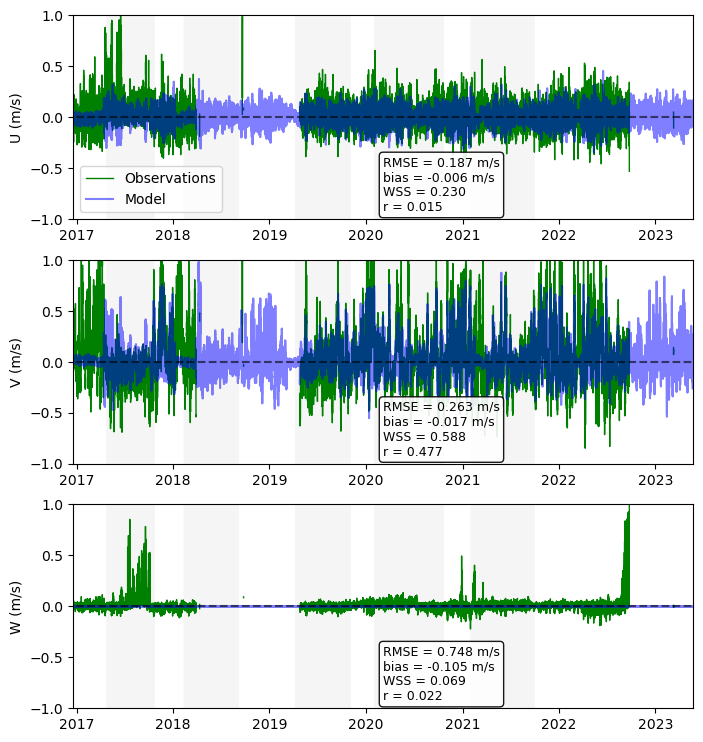

In [28]:
fig,ax = plt.subplots(3,1,figsize=(8,9))

ax[0].plot(df.datetime, df['eastward_sea_water_velocity (m.s-1)'],'g',lw=1,label='Observations')
ax[0].plot(df.datetime, df['model_u'],'b',label='Model',alpha=0.5)
ax[0].set_ylabel('U (m/s)')
ax[0].legend()
# plot the stats pannel
plot_panel(ax[0], df['eastward_sea_water_velocity (m.s-1)'], df['model_u'], (-0.1,0.1), 'm/s')

ax[1].plot(df.datetime, df['northward_sea_water_velocity (m.s-1)'],'g',lw=1,label='Observations')
ax[1].plot(df.datetime, df['model_v'],'b',label='Model',alpha=0.5)
ax[1].set_ylabel('V (m/s)')
# plot the stats pannel
plot_panel(ax[1], df['northward_sea_water_velocity (m.s-1)'], df['model_v'], (-0.1,0.1), 'm/s')

ax[2].plot(df.datetime, df['upward_sea_water_velocity (m.s-1)'],'g',lw=1,label='Observations')
ax[2].plot(df.datetime, df['model_w'],'b',label='Model',alpha=0.5)
ax[2].set_ylabel('W (m/s)')
# plot the stats pannel
plot_panel(ax[2], df['upward_sea_water_velocity (m.s-1)'], df['model_w'], (-0.1,0.1), 'm/s')

for i in range(len(ax)):
    ax[i].set_ylim([-1,1])
    ax[i].set_xlim([np.min(df.datetime),np.max(df.datetime)])
    ax[i].plot([np.min(df.index),np.max(df.index)],[0,0],'k--',alpha=0.6)

    for j in range(0, len(season),2):
        ax[i].fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')


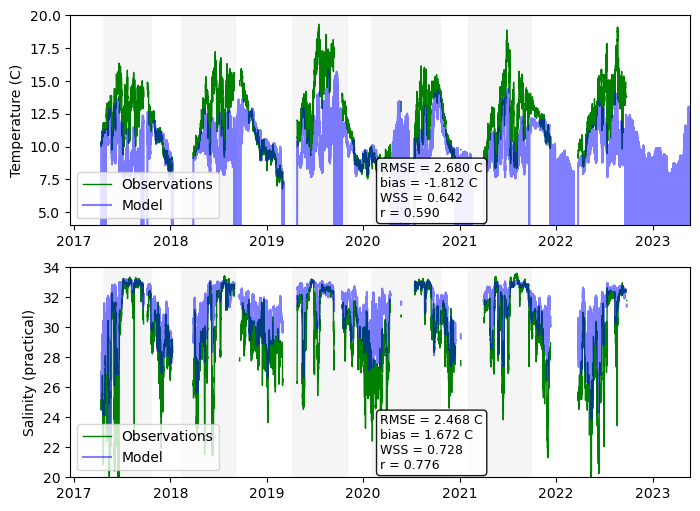

In [29]:
fig,ax = plt.subplots(2,1,figsize=(8,6))

ax[0].plot(df.datetime, df['sea_water_temperature (degree_Celsius)'],'g',lw=1,label='Observations')
ax[0].plot(df.datetime, df['model_t'],'b',label='Model',alpha=0.5)
ax[0].set_ylabel('Temperature (C)')
ax[0].legend(loc="lower left")
# plot the stats pannel
plot_panel(ax[0], df['sea_water_temperature (degree_Celsius)'], df['model_t'], (4,20), 'C')
ax[0].set_xlim([np.min(df.datetime),np.max(df.datetime)])

ax[1].plot(df.datetime, df['sea_water_practical_salinity (1e-3)'],'g',lw=1,label='Observations')
ax[1].plot(df.datetime, df['model_s'],'b',label='Model',alpha=0.5)
ax[1].set_ylabel('Salinity (practical)')
ax[1].legend(loc="lower left")
# plot the stats pannel
plot_panel(ax[1], df['sea_water_practical_salinity (1e-3)'], df['model_s'], (20,34), 'C')
ax[1].set_xlim([np.min(df.datetime),np.max(df.datetime)])

for j in range(0, len(season),2):
    ax[0].fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')
    ax[1].fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')


### middle, nearsurface 

In [40]:
df = pd.read_pickle("/data1/bbeutel/LO_output/extract_cast/ooi/ooi-ce07shsm_ns.p")

#change it to daily
df = df.set_index('datetime')
df = df.resample('D',axis=0).mean()
df['datetime'] = df.index
index = pd.Index(range(len(df)))
df.set_index(index,inplace=True)

lat = np.append(lat, df['latitude (degrees_north)'][0])
lon = np.append(lon, df['longitude (degrees_east)'][0])
d = np.append(d, gsw.z_from_p(df['sea_water_pressure (decibars)'][0], df['latitude (degrees_north)'][0]))
org = np.append(org, "ioo")
mes = np.append(mes, 'ctd')

# repeat bc has current and ctd
lat = np.append(lat, df['latitude (degrees_north)'][0])
lon = np.append(lon, df['longitude (degrees_east)'][0])
d = np.append(d, gsw.z_from_p(df['sea_water_pressure (decibars)'][0], df['latitude (degrees_north)'][0]))
org = np.append(org, "ioo")
mes = np.append(mes, 'cur')

# undo a conversion you did wrong while downloading
df['model_o'] = df['model_o']*1000
df['model_n'] = df['model_n']*1000

df.head()

,longitude (degrees_east),latitude (degrees_north),sea_water_pressure (decibars),sea_water_density (kg.m-3),sea_water_temperature (degree_Celsius),sea_water_practical_salinity (1e-3),eastward_sea_water_velocity (m.s-1),northward_sea_water_velocity (m.s-1),upward_sea_water_velocity (m.s-1),mole_concentration_of_dissolved_molecular_oxygen_in_sea_water (micromol.L-1),mole_concentration_of_nitrate_in_sea_water (micromol.L-1),mole_concentration_of_nitrate_in_sea_water_full (micromol.L-1),model_s,model_t,model_o,model_n,model_u,model_v,model_w,datetime
0,-124.56362,46.98767,7.084760,1022.180389,9.541764,28.745804,-0.065518,0.118716,0.008469,356.122864,5.953360,NaN,31.959852,10.476712,288906.205495,4360.809982,0.103769,0.015967,0.000123,2016-12-18 00:00:00+00:00
1,-124.56362,46.98767,6.728563,1022.474867,10.051696,29.228321,-0.100020,0.051814,0.005260,359.603256,5.072952,NaN,31.921772,10.575693,290581.995646,4072.017054,0.021827,0.217835,0.000204,2016-12-19 00:00:00+00:00
2,-124.56362,46.98767,6.703309,1023.518855,10.490249,30.659395,-0.091463,0.052603,0.020740,353.966929,2.930748,NaN,31.325712,10.100963,294323.891958,1324.033387,0.046786,0.269103,0.000330,2016-12-20 00:00:00+00:00
3,-124.56362,46.98767,7.080610,1023.809263,10.685680,31.071832,0.055401,0.083901,0.016031,377.663968,2.636744,NaN,30.781731,9.716218,294018.867493,792.057029,-0.159822,0.259616,0.000364,2016-12-21 00:00:00+00:00
4,-124.56362,46.98767,6.925726,1022.814770,10.450282,29.747565,0.155122,-0.016017,0.020635,341.198746,4.465936,NaN,31.366670,10.168348,292617.483775,1582.136244,-0.368085,0.053390,-0.000068,2016-12-22 00:00:00+00:00


(-0.1, 0.1)

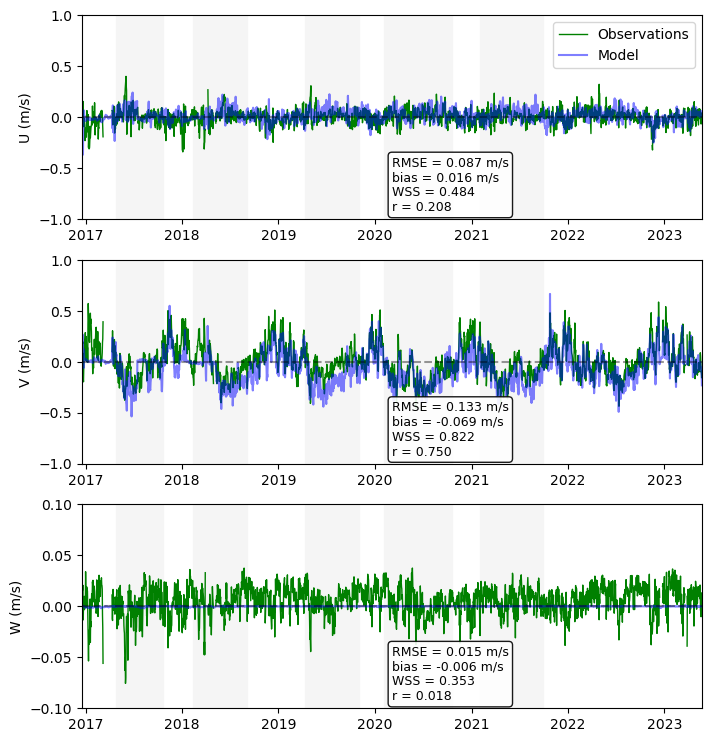

In [41]:
fig,ax = plt.subplots(3,1,figsize=(8,9))

ax[0].plot(df.datetime, df['eastward_sea_water_velocity (m.s-1)'],'g',lw=1,label='Observations')
ax[0].plot(df.datetime, df['model_u'],'b',label='Model',alpha=0.5)
ax[0].set_ylabel('U (m/s)')
ax[0].legend()
# plot the stats pannel
plot_panel(ax[0], df['eastward_sea_water_velocity (m.s-1)'], df['model_u'], (-0.1,0.1), 'm/s')

ax[1].plot(df.datetime, df['northward_sea_water_velocity (m.s-1)'],'g',lw=1,label='Observations')
ax[1].plot(df.datetime, df['model_v'],'b',label='Model',alpha=0.5)
ax[1].set_ylabel('V (m/s)')
# plot the stats pannel
plot_panel(ax[1], df['northward_sea_water_velocity (m.s-1)'], df['model_v'], (-0.1,0.1), 'm/s')

ax[2].plot(df.datetime, df['upward_sea_water_velocity (m.s-1)'],'g',lw=1,label='Observations')
ax[2].plot(df.datetime, df['model_w'],'b',label='Model',alpha=0.5)
ax[2].set_ylabel('W (m/s)')
# plot the stats pannel
plot_panel(ax[2], df['upward_sea_water_velocity (m.s-1)'], df['model_w'], (-0.1,0.1), 'm/s')

for i in range(len(ax)):
    ax[i].set_ylim([-1,1])
    ax[i].plot([np.min(df.datetime),np.max(df.datetime)],[0,0],'k--',alpha=0.4)
    ax[i].set_xlim([np.min(df.datetime),np.max(df.datetime)])
    ax[i].plot([np.min(df.index),np.max(df.index)],[0,0],'k--',alpha=0.6)

    for j in range(0, len(season),2):
        ax[i].fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')

ax[2].set_ylim([-0.1,0.1])

In [42]:
window_size = 15  # 15 day running mean based on smoothing from Foreman et al., 2011 - Trends in upwelling and downwelling winds along the BritishColumbia shelf
df['smoothed_obs_v'] = df['northward_sea_water_velocity (m.s-1)'].rolling(window=window_size).mean()
df['smoothed_mod_v'] = df['model_v'].rolling(window=window_size).mean()

In [43]:
updo = np.array([])
n=1

for i in range(len(df)-(n*2)):
    k=i+n
    if np.sign(np.mean(df['smoothed_obs_v'][(k-n):k])) != np.sign(np.mean(df['smoothed_obs_v'][k:(k+n)])):
        updo = np.append(updo,df.datetime[k])

len(updo)

250

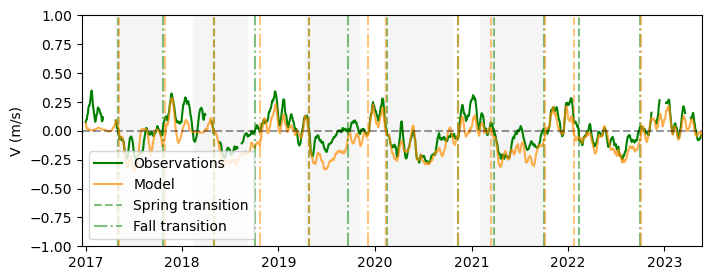

In [49]:
fig,ax = plt.subplots(1,1,figsize=(8,3))

# ax.plot(df.datetime, df['northward_sea_water_velocity (m.s-1)'],'g',lw=1,label='Observations')
# ax.plot(df.datetime, df['model_v'],'b',label='Model',alpha=0.5)

ax.plot(df.datetime, df['smoothed_obs_v'],'g',label='Observations')
ax.plot(df.datetime, df['smoothed_mod_v'],'darkorange',label='Model',alpha=0.7)

ax.set_ylabel('V (m/s)')
ax.set_ylim([-1,1])
ax.plot([np.min(df.datetime),np.max(df.datetime)],[0,0],'k--',alpha=0.4)
ax.set_xlim([np.min(df.datetime),np.max(df.datetime)])
ax.plot([np.min(df.index),np.max(df.index)],[0,0],'k--',alpha=0.6)

# observed spring transition:
ax.plot(np.repeat(pd.datetime(2017,5,4),2),[-1,1],'g--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2018,5,1),2),[-1,1],'g--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2019,4,28),2),[-1,1],'g--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2020,2,15),2),[-1,1],'g--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2021,3,27),2),[-1,1],'g--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2022,2,10),2),[-1,1],'g--', alpha=0.5, label ="Spring transition")
# observed fall transition:
ax.plot(np.repeat(pd.datetime(2017,10,22),2),[-1,1],'g-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2018,10,4),2),[-1,1],'g-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2019,9,20),2),[-1,1],'g-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2020,11,12),2),[-1,1],'g-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2021,10,1),2),[-1,1],'g-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2022,9,30),2),[-1,1],'g-.', alpha=0.5, label ="Fall transition")

# model spring transition:
ax.plot(np.repeat(pd.datetime(2017,5,6),2),[-1,1],c='darkorange',ls='--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2018,5,1),2),[-1,1],c='darkorange',ls='--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2019,4,26),2),[-1,1],c='darkorange',ls='--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2020,2,12),2),[-1,1],c='darkorange',ls='--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2021,3,17),2),[-1,1],c='darkorange',ls='--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2022,1,25),2),[-1,1],c='darkorange',ls='--', alpha=0.5)
# model fall transition:
ax.plot(np.repeat(pd.datetime(2017,10,30),2),[-1,1],c='darkorange',ls='-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2018,10,25),2),[-1,1],c='darkorange',ls='-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2019,12,5),2),[-1,1],c='darkorange',ls='-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2020,11,12),2),[-1,1],c='darkorange',ls='-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2021,10,7),2),[-1,1],c='darkorange',ls='-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2022,10,5),2),[-1,1],c='darkorange',ls='-.', alpha=0.5)

ax.legend(loc="lower left")

for j in range(0, len(season),2):
    ax.fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')

In [35]:
# lets calculate some statistics for the difference between model and observation timing
mod_spring = np.array([pd.datetime(2017,5,6).timetuple().tm_yday,pd.datetime(2018,5,1).timetuple().tm_yday,pd.datetime(2019,4,26).timetuple().tm_yday,pd.datetime(2020,2,12).timetuple().tm_yday,pd.datetime(2021,3,17).timetuple().tm_yday,pd.datetime(2022,1,25).timetuple().tm_yday])
mod_fall = np.array([pd.datetime(2017,10,30).timetuple().tm_yday,pd.datetime(2018,10,25).timetuple().tm_yday,pd.datetime(2019,12,5).timetuple().tm_yday,pd.datetime(2020,11,12).timetuple().tm_yday,pd.datetime(2021,10,7).timetuple().tm_yday,pd.datetime(2022,10,5).timetuple().tm_yday])

obs_spring = np.array([pd.datetime(2017,5,4).timetuple().tm_yday, pd.datetime(2018,5,1).timetuple().tm_yday, pd.datetime(2019,4,28).timetuple().tm_yday, pd.datetime(2020,2,15).timetuple().tm_yday, pd.datetime(2021,3,27).timetuple().tm_yday, pd.datetime(2022,2,10).timetuple().tm_yday])
obs_fall =  np.array([pd.datetime(2017,10,22).timetuple().tm_yday, pd.datetime(2018,10,4).timetuple().tm_yday, pd.datetime(2019,9,20).timetuple().tm_yday, pd.datetime(2020,11,12).timetuple().tm_yday, pd.datetime(2021,10,1).timetuple().tm_yday, pd.datetime(2022,9,30).timetuple().tm_yday])

In [36]:
# spring
x = obs_spring
y = mod_spring
st = np.std(x)
rmse = np.sqrt(np.mean((y - x)**2))
print("standard deviation in observed spring transition = "+str(int(st)))
print("RMSE between model and observations in spring transition = "+str(int(rmse)))
print('\n')

# fall
x = obs_fall
y = mod_fall
st = np.std(x)
rmse = np.sqrt(np.mean((y - x)**2))
print("standard deviation in observed fall transition = "+str(int(st)))
print("RMSE between model and observations in fall transition = "+str(int(rmse)))
print('\n')


# fall without that weird 2019 transition
x = np.append(obs_fall[0:2],obs_fall[3:])
y = np.append(mod_fall[0:2],mod_fall[3:])
st = np.std(x)
rmse = np.sqrt(np.mean((y - x)**2))
print("standard deviation in observed fall transition = "+str(int(st)))
print("RMSE between model and observations in fall transition = "+str(int(rmse)))

standard deviation in observed spring transition = 34
RMSE between model and observations in spring transition = 7


standard deviation in observed fall transition = 17
RMSE between model and observations in fall transition = 32


standard deviation in observed fall transition = 16
RMSE between model and observations in fall transition = 10


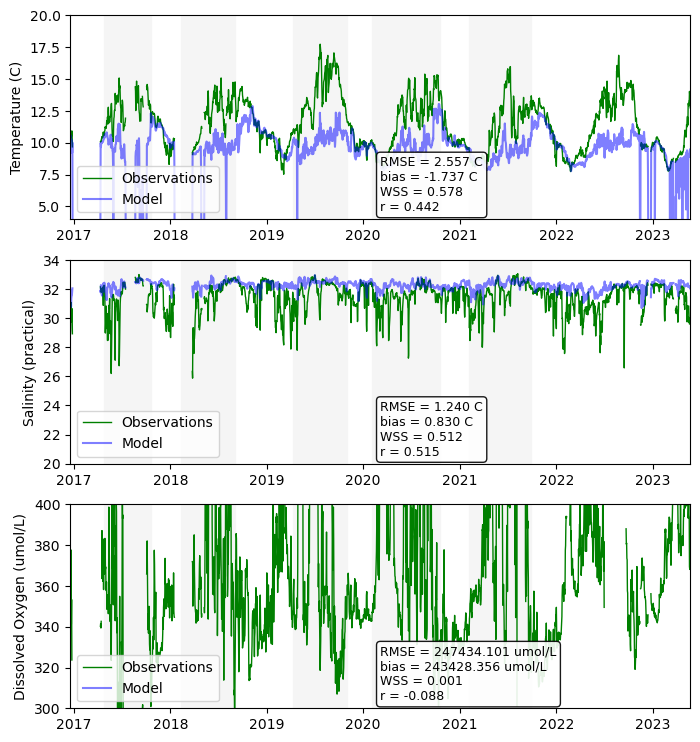

In [37]:
fig,ax = plt.subplots(3,1,figsize=(8,9))

ax[0].plot(df.datetime, df['sea_water_temperature (degree_Celsius)'],'g',lw=1,label='Observations')
ax[0].plot(df.datetime, df['model_t'],'b',label='Model',alpha=0.5)
ax[0].set_ylabel('Temperature (C)')
ax[0].legend(loc="lower left")
# plot the stats pannel
plot_panel(ax[0], df['sea_water_temperature (degree_Celsius)'], df['model_t'], (4,20), 'C')
ax[0].set_xlim([np.min(df.datetime),np.max(df.datetime)])

ax[1].plot(df.datetime, df['sea_water_practical_salinity (1e-3)'],'g',lw=1,label='Observations')
ax[1].plot(df.datetime, df['model_s'],'b',label='Model',alpha=0.5)
ax[1].set_ylabel('Salinity (practical)')
ax[1].legend(loc="lower left")
# plot the stats pannel
plot_panel(ax[1], df['sea_water_practical_salinity (1e-3)'], df['model_s'], (20,34), 'C')
ax[1].set_xlim([np.min(df.datetime),np.max(df.datetime)])

ax[2].plot(df.datetime, df['mole_concentration_of_dissolved_molecular_oxygen_in_sea_water (micromol.L-1)'],'g',lw=1,label='Observations')
ax[2].plot(df.datetime, df['model_o'],'b',label='Model',alpha=0.5)
ax[2].set_ylabel('Dissolved Oxygen (umol/L)')
ax[2].legend(loc="lower left")
# plot the stats pannel
plot_panel(ax[2], df['mole_concentration_of_dissolved_molecular_oxygen_in_sea_water (micromol.L-1)'], df['model_o'], (300,400), 'umol/L')
ax[2].set_xlim([np.min(df.datetime),np.max(df.datetime)])

for j in range(0, len(season),2):
    ax[0].fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')
    ax[1].fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')
    ax[2].fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')

### farthest, nearsurface

In [38]:
df = pd.read_pickle("/data1/bbeutel/LO_output/extract_cast/ooi/ooi-ce09ossm_ns.p")

lat = np.append(lat, df['latitude (degrees_north)'][0])
lon = np.append(lon, df['longitude (degrees_east)'][0])
d = np.append(d, gsw.z_from_p(df['sea_water_pressure (decibars)'][0], df['latitude (degrees_north)'][0]))
org = np.append(org, "ioo")
mes = np.append(mes, 'ctd')

# repeat bc has current and ctd
lat = np.append(lat, df['latitude (degrees_north)'][0])
lon = np.append(lon, df['longitude (degrees_east)'][0])
d = np.append(d, gsw.z_from_p(df['sea_water_pressure (decibars)'][0], df['latitude (degrees_north)'][0]))
org = np.append(org, "ioo")
mes = np.append(mes, 'cur')

# undo a conversion you did wrong while downloading
df['model_o'] = df['model_o']*1000
df['model_n'] = df['model_n']*1000

df.head()

,longitude (degrees_east),latitude (degrees_north),sea_water_pressure (decibars),sea_water_density (kg.m-3),sea_water_temperature (degree_Celsius),sea_water_practical_salinity (1e-3),eastward_sea_water_velocity (m.s-1),northward_sea_water_velocity (m.s-1),upward_sea_water_velocity (m.s-1),mole_concentration_of_dissolved_molecular_oxygen_in_sea_water (micromol.L-1),mole_concentration_of_nitrate_in_sea_water (micromol.L-1),mole_concentration_of_nitrate_in_sea_water_full (micromol.L-1),datetime,model_s,model_t,model_o,model_n,model_u,model_v,model_w
0,-124.9504,46.8545,7.378249,1023.825629,10.147861,30.976066,-0.088145,0.081708,0.02550,344.568655,2.216234,2.211545,2016-12-18 00:00:00+00:00,32.191432,10.939868,278918.487549,7327.755928,0.030383,0.138239,-0.000997
1,-124.9504,46.8545,7.435205,1023.804227,10.057911,30.929445,-0.141174,0.072725,0.02000,341.437134,2.174087,2.176789,2016-12-18 01:00:00+00:00,32.192038,10.934504,278858.764648,7336.701870,-0.079311,0.070767,-0.000247
2,-124.9504,46.8545,7.413689,1023.754555,9.983513,30.850407,-0.187169,0.021154,-0.00575,342.477440,2.253402,2.253474,2016-12-18 02:00:00+00:00,32.191640,10.917109,278867.034912,7328.745365,-0.017578,0.107542,0.000230
3,-124.9504,46.8545,7.428309,1023.650753,9.937561,30.707727,-0.188115,0.037810,-0.00775,343.496268,2.290362,2.295780,2016-12-18 03:00:00+00:00,32.192790,10.911325,278810.882568,7338.782310,-0.054963,0.123057,-0.001365
4,-124.9504,46.8545,7.411648,1023.622648,9.960285,30.676492,-0.192885,0.079228,0.00475,342.836986,2.369114,2.366754,2016-12-18 04:00:00+00:00,32.193322,10.904772,278778.045654,7342.080116,-0.052113,0.122036,-0.000128


(-0.1, 0.1)

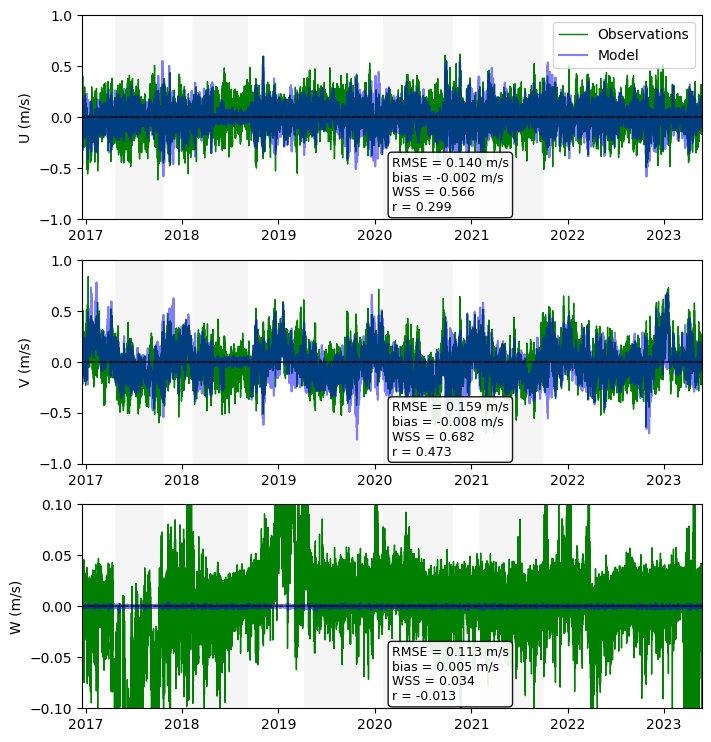

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(8,9))

ax[0].plot(df.datetime, df['eastward_sea_water_velocity (m.s-1)'],'g',lw=1,label='Observations')
ax[0].plot(df.datetime, df['model_u'],'b',label='Model',alpha=0.5)
ax[0].set_ylabel('U (m/s)')
ax[0].legend()
# plot the stats pannel
plot_panel(ax[0], df['eastward_sea_water_velocity (m.s-1)'], df['model_u'], (-0.1,0.1), 'm/s')

ax[1].plot(df.datetime, df['northward_sea_water_velocity (m.s-1)'],'g',lw=1,label='Observations')
ax[1].plot(df.datetime, df['model_v'],'b',label='Model',alpha=0.5)
ax[1].set_ylabel('V (m/s)')
# plot the stats pannel
plot_panel(ax[1], df['northward_sea_water_velocity (m.s-1)'], df['model_v'], (-0.1,0.1), 'm/s')

ax[2].plot(df.datetime, df['upward_sea_water_velocity (m.s-1)'],'g',lw=1,label='Observations')
ax[2].plot(df.datetime, df['model_w'],'b',label='Model',alpha=0.5)
ax[2].set_ylabel('W (m/s)')
# plot the stats pannel
plot_panel(ax[2], df['upward_sea_water_velocity (m.s-1)'], df['model_w'], (-0.1,0.1), 'm/s')

for i in range(len(ax)):
    ax[i].set_ylim([-1,1])
    ax[i].plot([np.min(df.datetime),np.max(df.datetime)],[0,0],'k--',alpha=0.4)
    ax[i].set_xlim([np.min(df.datetime),np.max(df.datetime)])
    ax[i].plot([np.min(df.index),np.max(df.index)],[0,0],'k--',alpha=0.6)

    for j in range(0, len(season),2):
        ax[i].fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')

ax[2].set_ylim([-0.1,0.1])

In [ ]:
window_size = 15 * 24 # 15 day running mean based on smoothing from Foreman et al., 2011 - Trends in upwelling and downwelling winds along the BritishColumbia shelf
df['smoothed_obs_v'] = df['northward_sea_water_velocity (m.s-1)'].rolling(window=window_size).mean()
df['smoothed_mod_v'] = df['model_v'].rolling(window=window_size).mean()

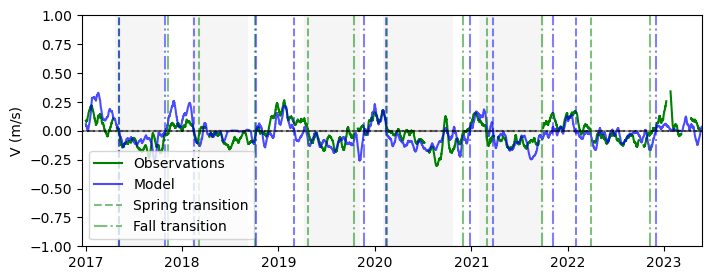

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,3))

# ax.plot(df.datetime, df['northward_sea_water_velocity (m.s-1)'],'g',lw=1,label='Observations')
# ax.plot(df.datetime, df['model_v'],'b',label='Model',alpha=0.5)

ax.plot(df.datetime, df['smoothed_obs_v'],'g',label='Observations')
ax.plot(df.datetime, df['smoothed_mod_v'],'b',label='Model',alpha=0.7)

ax.set_ylabel('V (m/s)')
ax.set_ylim([-1,1])
ax.plot([np.min(df.datetime),np.max(df.datetime)],[0,0],'k--',alpha=0.4)
ax.set_xlim([np.min(df.datetime),np.max(df.datetime)])
ax.plot([np.min(df.index),np.max(df.index)],[0,0],'k--',alpha=0.6)

# observed spring transition:
ax.plot(np.repeat(pd.datetime(2017,5,7),2),[-1,1],'g--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2018,3,5),2),[-1,1],'g--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2019,4,23),2),[-1,1],'g--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2020,2,18),2),[-1,1],'g--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2021,3,1),2),[-1,1],'g--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2022,3,29),2),[-1,1],'g--', alpha=0.5, label ="Spring transition")
# observed fall transition:
ax.plot(np.repeat(pd.datetime(2017,11,8),2),[-1,1],'g-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2018,10,5),2),[-1,1],'g-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2019,10,15),2),[-1,1],'g-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2020,11,30),2),[-1,1],'g-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2021,9,25),2),[-1,1],'g-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2022,11,9),2),[-1,1],'g-.', alpha=0.5, label ="Fall transition")

# model spring transition:
ax.plot(np.repeat(pd.datetime(2017,5,9),2),[-1,1],'b--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2018,2,15),2),[-1,1],'b--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2019,3,2),2),[-1,1],'b--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2020,2,13),2),[-1,1],'b--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2021,3,25),2),[-1,1],'b--', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2022,2,2),2),[-1,1],'b--', alpha=0.5)
# model fall transition:
ax.plot(np.repeat(pd.datetime(2017,10,30),2),[-1,1],'b-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2018,10,10),2),[-1,1],'b-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2019,11,23),2),[-1,1],'b-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2020,12,27),2),[-1,1],'b-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2021,11,5),2),[-1,1],'b-.', alpha=0.5)
ax.plot(np.repeat(pd.datetime(2022,12,1),2),[-1,1],'b-.', alpha=0.5)


ax.legend(loc="lower left")

for j in range(0, len(season),2):
    ax.fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')

In [ ]:
obs_spring = np.array([pd.datetime(2017,5,7).timetuple().tm_yday,pd.datetime(2018,3,5).timetuple().tm_yday,pd.datetime(2019,4,23).timetuple().tm_yday,pd.datetime(2020,2,18).timetuple().tm_yday,pd.datetime(2021,3,1).timetuple().tm_yday,pd.datetime(2022,3,29).timetuple().tm_yday])
obs_fall = np.array([pd.datetime(2017,11,8).timetuple().tm_yday, pd.datetime(2018,10,5).timetuple().tm_yday, pd.datetime(2019,10,15).timetuple().tm_yday, pd.datetime(2020,11,30).timetuple().tm_yday, pd.datetime(2021,9,25).timetuple().tm_yday, pd.datetime(2022,11,9).timetuple().tm_yday])

mod_spring =  np.array([pd.datetime(2017,5,9).timetuple().tm_yday, pd.datetime(2018,2,15).timetuple().tm_yday, pd.datetime(2019,3,2).timetuple().tm_yday, pd.datetime(2020,2,13).timetuple().tm_yday, pd.datetime(2021,3,25).timetuple().tm_yday, pd.datetime(2022,2,2).timetuple().tm_yday])
mod_fall =  np.array([pd.datetime(2017,10,30).timetuple().tm_yday, pd.datetime(2018,10,10).timetuple().tm_yday, pd.datetime(2019,11,23).timetuple().tm_yday, pd.datetime(2020,12,27).timetuple().tm_yday, pd.datetime(2021,11,5).timetuple().tm_yday, pd.datetime(2022,12,1).timetuple().tm_yday])

In [ ]:
# spring
x = obs_spring
y = mod_spring
st = np.std(x)
rmse = np.sqrt(np.mean((y - x)**2))
print("standard deviation in observed spring transition = "+str(int(st)))
print("RMSE between model and observations in spring transition = "+str(int(rmse)))
print('\n')

# fall
x = obs_fall
y = mod_fall
st = np.std(x)
rmse = np.sqrt(np.mean((y - x)**2))
print("standard deviation in observed fall transition = "+str(int(st)))
print("RMSE between model and observations in fall transition = "+str(int(rmse)))

standard deviation in observed spring transition = 28
RMSE between model and observations in spring transition = 33


standard deviation in observed fall transition = 23
RMSE between model and observations in fall transition = 27


# map where timeseries were measured

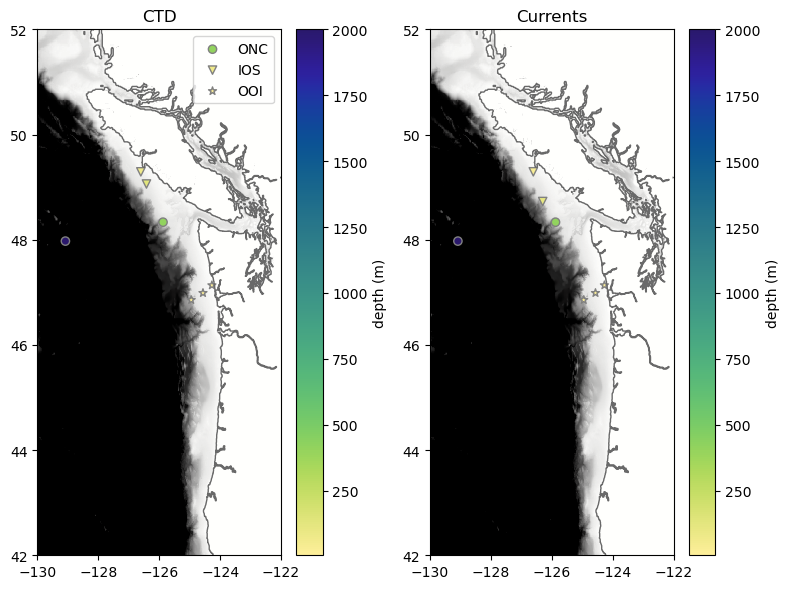

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8, 6))

for i in range(len(ax)):
    ax[i].contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
    ax[i].contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
    ax[i].pcolormesh(grid.lon_rho, grid.lat_rho,grid.h, vmin=0, vmax=2000, cmap=cm.cm.gray_r)
    ax[i].set_ylim([42,52])
    ax[i].set_xlim([-130,-122])


c = ax[0].scatter(lon[(mes=='ctd') & (org=='onc')], lat[(mes=='ctd') & (org=='onc')], c=d[(mes=='ctd') & (org=='onc')], cmap=cm.cm.haline_r, marker='o', edgecolors='grey', vmin=5, vmax=2000, label='ONC')
fig.colorbar(c, ax=ax[0], label='depth (m)')
ax[0].scatter(lon[(mes=='ctd') & (org=='ios')], lat[(mes=='ctd') & (org=='ios')], c=d[(mes=='ctd') & (org=='ios')], cmap=cm.cm.haline_r, marker='v', edgecolors='grey', vmin=5, vmax=2000, label='IOS')
ax[0].scatter(lon[(mes=='ctd') & (org=='ioo')], lat[(mes=='ctd') & (org=='ioo')], c=d[(mes=='ctd') & (org=='ioo')], cmap=cm.cm.haline_r, marker='*', edgecolors='grey', vmin=5, vmax=2000, label='OOI')
ax[0].legend()

c = ax[1].scatter(lon[(mes=='cur') & (org=='onc')], lat[(mes=='cur') & (org=='onc')], c=d[(mes=='cur') & (org=='onc')], cmap=cm.cm.haline_r, marker='o', edgecolors='grey', vmin=5, vmax=2000, label='ONC')
fig.colorbar(c, ax=ax[1], label='depth (m)')
ax[1].scatter(lon[(mes=='cur') & (org=='ios')], lat[(mes=='cur') & (org=='ios')], c=d[(mes=='cur') & (org=='ios')], cmap=cm.cm.haline_r, marker='v', edgecolors='grey', vmin=5, vmax=2000, label='IOS')
ax[1].scatter(lon[(mes=='cur') & (org=='ioo')], lat[(mes=='cur') & (org=='ioo')], c=d[(mes=='cur') & (org=='ioo')], cmap=cm.cm.haline_r, marker='*', edgecolors='grey', vmin=5, vmax=2000, label='OOI')

ax[0].set_title('CTD')
ax[1].set_title('Currents')


plt.tight_layout()